In [1]:
# 0. 필요한 모듈 임포트
# %config Completer.use_jedi = False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# numpy 임의성
np.random.seed(45)

In [3]:
# 1. 데이터셋 가지고 오기
dataset = pd.read_csv('./DataSet/MNIST_preprocessed.csv', sep=',', header=None).values
dataset.shape

(300, 794)

In [4]:
# 입력, 목표 변수 데이터 셋 나누기
# 0 ~ 783 : MNIST dataset
X = dataset[:, 0:784]
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# 784 ~ 793 : MNIST 데이터의 목표변수를 One hot encoding한 결과
Y = dataset[:, 784:]
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# training, testing 데이터 셋 나누기
X_train, X_test = X[0:250,], X[250:,]
Y_train, Y_test = Y[0:250,], Y[250:,]
X_train[0].shape

(784,)

In [7]:
# 시그모이드 함수 정의
def sigmoid(x):
    """시그모이드 함수"""
    return 1/(1 + np.exp(-x))

def d_sigmoid(x):
    """시그모이드 미분 함수"""
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [8]:
# 신경망의 가중치와 편향을 초기화해주는 함수
def initialize_parameters(neurons_per_layer):
    """신경망의 가중치와 편향을 초기화해주는 함수"""
    L = len(neurons_per_layer) - 1 # 층 개수 저장
    parameters = {}
    
    # 1층부터 L층까지 돌면서 가중치와 편향 초기화
    for l in range(1,L+1):
        
        # l층 가중치 행렬의 차원은 (l층 뉴런개수)x(l-1층 뉴런의 개수)
        # l층 편향벡터의 길이는 l
        parameters['W' + str(l)] = np.random.randn(neurons_per_layer[l],neurons_per_layer[l-1])/np.sqrt(neurons_per_layer[l])
        parameters['b' + str(l)] = np.random.randn(neurons_per_layer[l])/np.sqrt(neurons_per_layer[l])
        
    return parameters

# # 테스트코드
# neurons_per_layer = [10, 5, 5, 3]
# parameters = initialize_parameters(neurons_per_layer)
# print("parameter : \n {}\n\n".format(parameters))
# print("lenth of parameter : {}".format(len(parameters)))

In [9]:
def initialize_zero_gradients(neurons_per_layer):
    """신경망의 편미분 값을 모두 0으로 초기화해주는 함수"""
    L = len(neurons_per_layer) - 1  # 입력층을 포함함 층 개수 저장
    gradients = {}

    # 1층 부터 L 층까지 돌면서 가중치와 편향 초기화
    for l in range(1, L + 1):
        gradients["dW" + str(l)] = np.zeros([neurons_per_layer[l], neurons_per_layer[l - 1]])
        gradients["db" + str(l)] = np.zeros([neurons_per_layer[l]])

    return gradients

In [10]:
# 순전파 Forward propergate 함수 정의
def feed_forward(x, parameters):
    """순전파 함수"""
    cache = {'a0': x}  # 0 번째 층 출력 저장
    L = len(parameters) // 2  # 층 수 저장 --> 파라미터에 whigt, bias있으니까 2로 나눔
    
    for l in range(1, L+1):
        # 전 층 뉴런의 출력, 현재 층 뉴런들의 가중치, 편향 데이터를 가지고 온다 (여기에 코드를 작성하세요)
        a_prev = cache['a' + str(l-1)]
        W = parameters['W'+ str(l)]
        b = parameters['b'+ str(l)]
        
        # 가지고 온 데이터로 z와 a를 계산한다. (여기에 코드를 작성하세요)
        z = W @ a_prev + b
        a = sigmoid(z)

        # 결과 값을 캐시에 저장한다.
        cache['z' + str(l)] = z
        cache['a' + str(l)] = a
                
    return a, cache

# 테스트 코드
neurons_per_layer = [784, 128, 64, 10]
parameters = initialize_parameters(neurons_per_layer)
feed_forward(X_train[0], parameters)[0]

array([0.3437484 , 0.98087844, 0.56103509, 0.08079231, 0.44007264,
       0.88045662, 0.07428953, 0.14584982, 0.87401404, 0.17412678])

In [11]:
def compute_accuracy(x_val, y_val, parameters):
    """테스트 데이터에서 예측값들의 성능을 계산하는 함수"""
    predictions = []

    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(y))

    return np.mean(predictions)

In [12]:
def compute_loss(x_val, y_val, parameters):
    """학습 데이터에서 현재 모델의 손실을 계산하는 함수"""
    loss = 0
    
    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        loss += np.mean((output - y)**2) / 2
        
    return loss / len(x_val)

In [13]:
def back_prop(prediction, y, cache, parameters):
    """역전파 함수"""
    gradients = {}
    L = len(cache) // 2
    da = (prediction - y) / y.shape[0]
    
    for layer in range(L, 0, -1):
        # 역전파 행렬 연산을 사용해서 각 요소에 대한 편미분 계산
        # 여기에 코드를 작성하세요
        a_prev = cache['a' + str(layer-1)]
        z = cache['z' + str(layer)]
        W = parameters['W' + str(layer)]
        
        # 가중치와 편향 + 전 층 뉴런 출력에 대한 편미분 계산
        db = da * d_sigmoid(z)
        dW = np.outer(db, a_prev)
        da = W.T @ db
        
        
        # 계산한 편미분 값들을 저장
        gradients['dW' + str(layer)] = dW
        gradients['db' + str(layer)] = db
    
    # 계산한 편미분 값들 리턴
    return gradients

In [14]:
def update(parameters, gradients, alpha):
    """계산한 경사로 가중치와 편향을 업데이트 하는 함수"""
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] -= alpha * gradients['dW'+str(layer)]
        parameters['b'+str(layer)] -= alpha * gradients['db'+str(layer)]
    
    return parameters

In [15]:
def train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, epoch, alpha):
    """신경망을 학습시키는 함수"""
    parameters = initialize_parameters(neurons_per_layer)
    loss_list = []
    m = X_train.shape[0]
    
    # epoch 번 경사 하강을 한다
    for i in range(epoch):
        gradients_mean = initialize_zero_gradients(neurons_per_layer)
        
        # 학습 데이터마다 경사를 계산하고 이를 학습 데이터 개수 m으로 나누어 더함
        for x, y in zip(X_train, Y_train):
            prediction, cache = feed_forward(x, parameters)
            gradients = back_prop(prediction, y, cache, parameters)
            for k, v in gradients.items():
                gradients_mean[k] += v / m
        
        # 편미분 평균값으로 가중치와 편향 업데이트
        parameters = update(parameters, gradients_mean, alpha)
        loss_list.append(compute_loss(X_train, Y_train, parameters))
        print('{}번째 경사 하강, 테스트 셋에서 성능: {}'.format(i+1, round(compute_accuracy(X_test, Y_test, parameters), 2)))     
            
    return loss_list, parameters

1번째 경사 하강, 테스트 셋에서 성능: 0.1
2번째 경사 하강, 테스트 셋에서 성능: 0.12
3번째 경사 하강, 테스트 셋에서 성능: 0.1
4번째 경사 하강, 테스트 셋에서 성능: 0.1
5번째 경사 하강, 테스트 셋에서 성능: 0.1
6번째 경사 하강, 테스트 셋에서 성능: 0.1
7번째 경사 하강, 테스트 셋에서 성능: 0.1
8번째 경사 하강, 테스트 셋에서 성능: 0.1
9번째 경사 하강, 테스트 셋에서 성능: 0.1
10번째 경사 하강, 테스트 셋에서 성능: 0.1
11번째 경사 하강, 테스트 셋에서 성능: 0.1
12번째 경사 하강, 테스트 셋에서 성능: 0.1
13번째 경사 하강, 테스트 셋에서 성능: 0.1
14번째 경사 하강, 테스트 셋에서 성능: 0.12
15번째 경사 하강, 테스트 셋에서 성능: 0.12
16번째 경사 하강, 테스트 셋에서 성능: 0.12
17번째 경사 하강, 테스트 셋에서 성능: 0.14
18번째 경사 하강, 테스트 셋에서 성능: 0.16
19번째 경사 하강, 테스트 셋에서 성능: 0.16
20번째 경사 하강, 테스트 셋에서 성능: 0.16
21번째 경사 하강, 테스트 셋에서 성능: 0.16
22번째 경사 하강, 테스트 셋에서 성능: 0.22
23번째 경사 하강, 테스트 셋에서 성능: 0.22
24번째 경사 하강, 테스트 셋에서 성능: 0.22
25번째 경사 하강, 테스트 셋에서 성능: 0.22


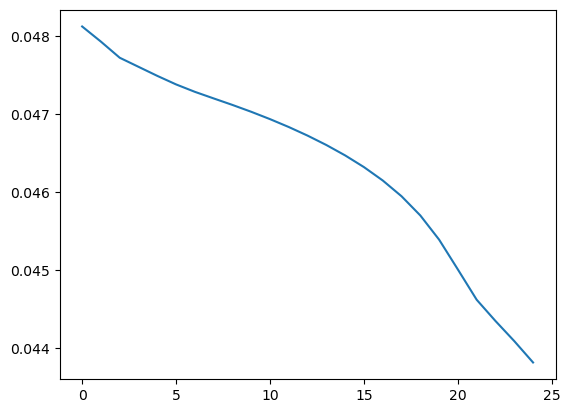

In [16]:
#디버깅을 위한 시각화 코드(쥬피터를 사용하시면 실행 코드 가장 아래줄에 넣어주세요!)



# 테스트 코드
neurons_per_layer = [784, 128, 64, 10]
loss_list, parameters = train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, 25, 30)

plt.plot(loss_list)
plt.show()